In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import numpy as np
import pandas as pd
#import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
#from tensorflow import keras
#
from tensorflow.keras.layers import Input, LSTM, Dense, GRU
from tensorflow.keras.models import Model
#
from tensorflow.keras.optimizers import Adam
#
from tensorflow.keras.utils import plot_model
#
from sklearn.preprocessing import MinMaxScaler
#

In [3]:
print("Versión de Tensorflow: ", tf.__version__)


Versión de Tensorflow:  2.3.0


In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
#
#sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10

In [5]:
#
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
trend = .1
#
time = np.arange(0, 100, 0.1)
sin =  trend*time + np.sin(time) + np.random.normal(scale=0.5, size=len(time))

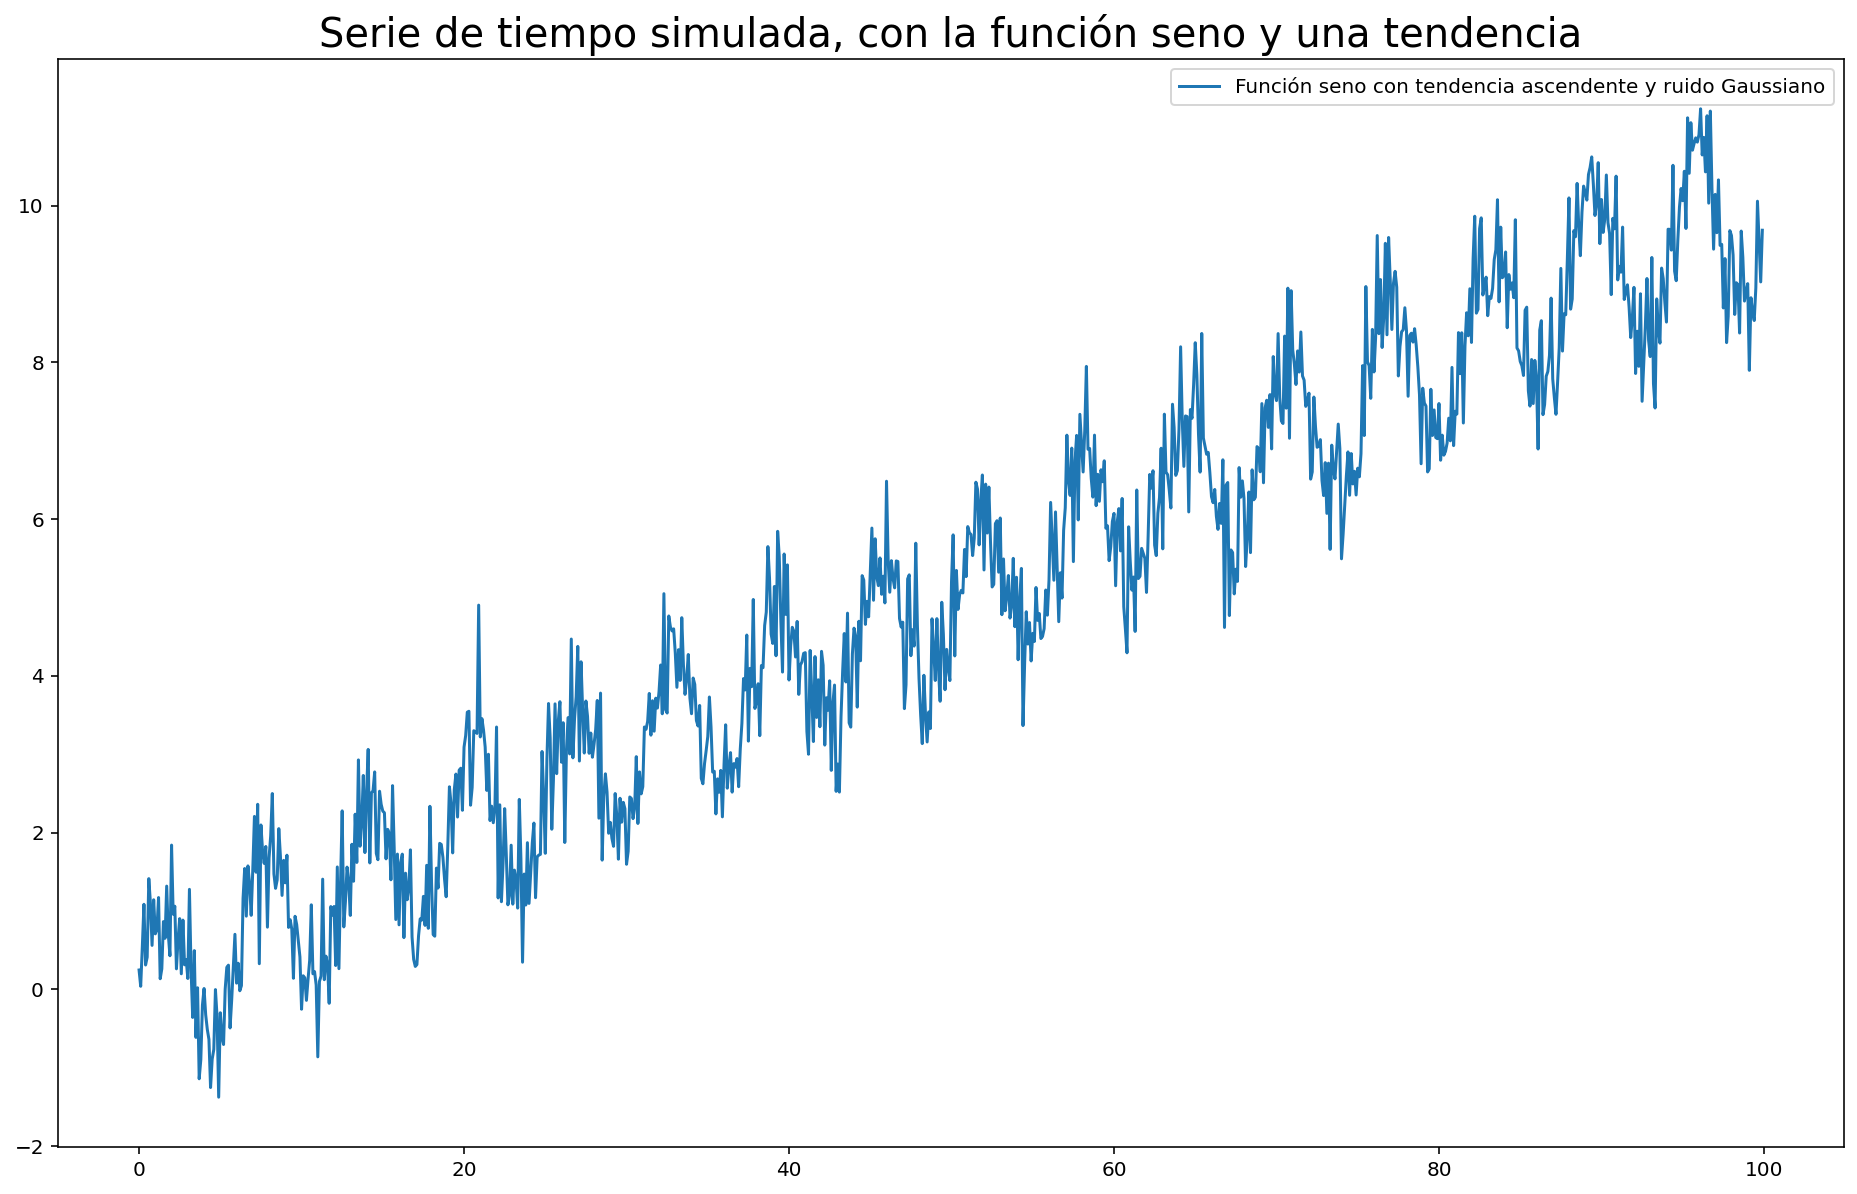

In [6]:


plt.plot(time, sin, label='Función seno con tendencia ascendente y ruido Gaussiano');
plt.title("Serie de tiempo simulada, con la función seno y una tendencia", size = 20)
plt.legend();
plt.show()

In [7]:
#crea un dataset 
#
df1 = pd.DataFrame(sin, index=time, columns=['serie'])
# crea el objeto  scaler y escala los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df1.values)
#
dataset = pd.DataFrame(scaled_data,index=df1.index, columns=['serie'])
#

In [8]:
dataset.shape


(1000, 1)

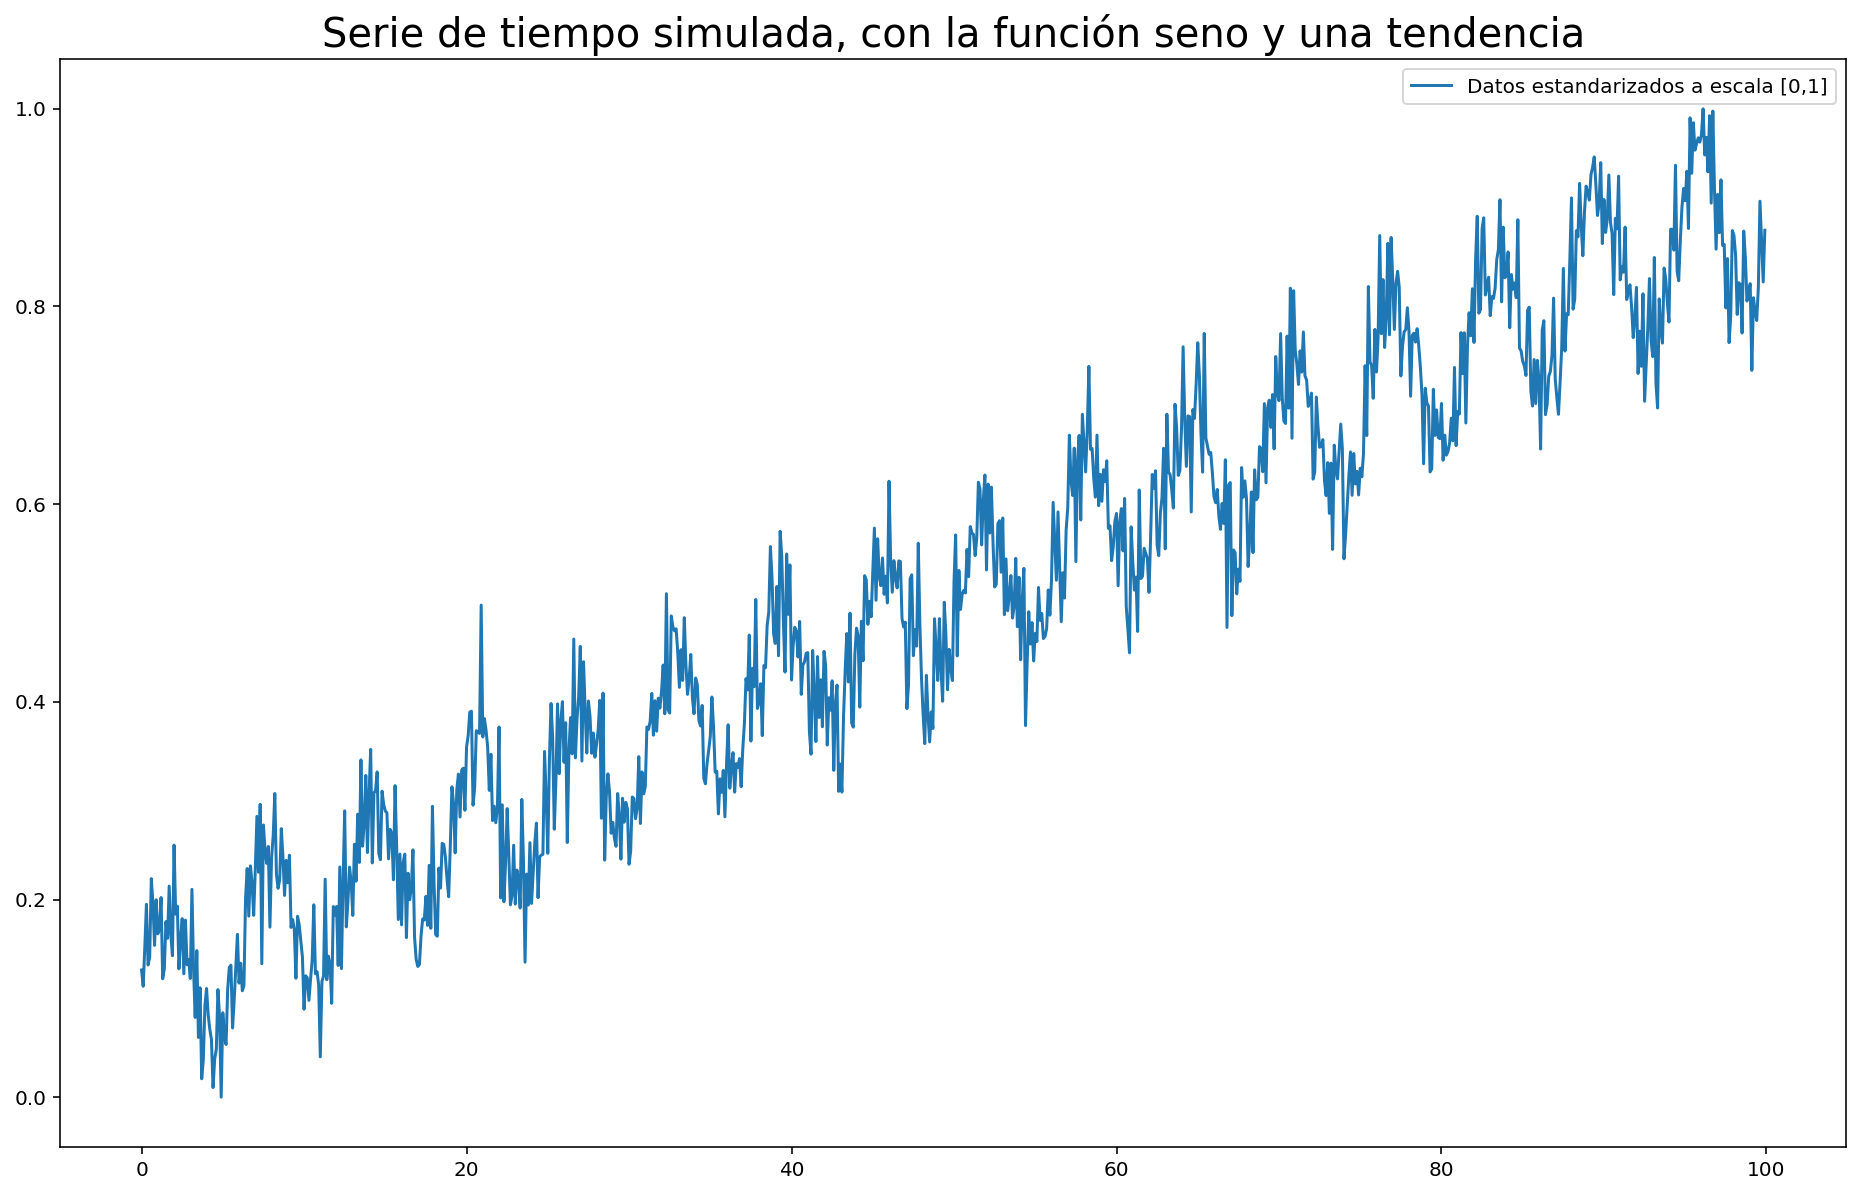

In [9]:

#serie_0_1 = dataset.serie_0_1.values

plt.plot(time, dataset, label='Datos estandarizados a escala [0,1]');
plt.title("Serie de tiempo simulada, con la función seno y una tendencia", size = 20)
plt.legend();
plt.show()

In [10]:
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset.iloc[0:train_size], dataset.iloc[train_size:len(df1)]
len_train = len(train)
len_test = len(test)
print(len_train, len_test)


800 200


In [11]:
train.shape


(800, 1)

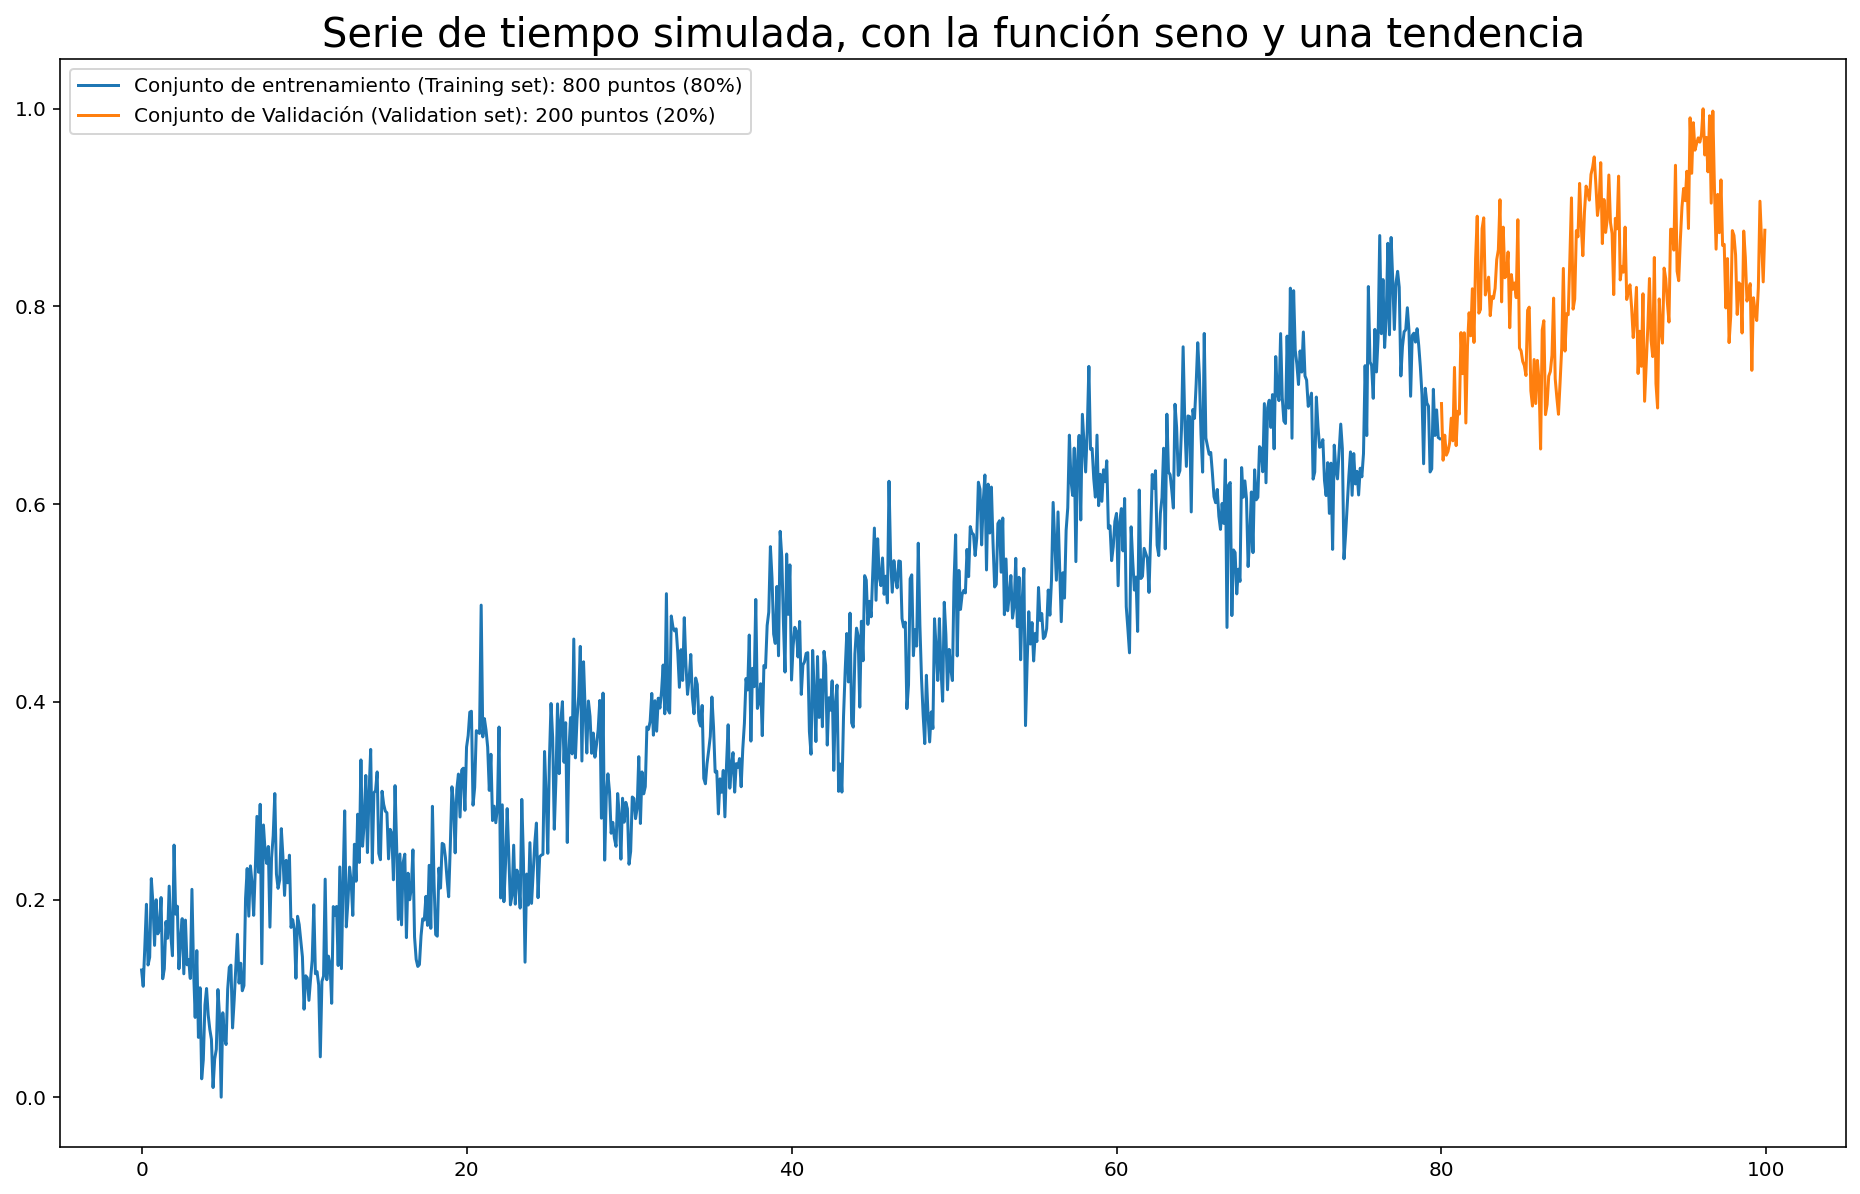

In [12]:

#plt.figure(figsize=(16,8))
plt.plot(train, label='Conjunto de entrenamiento (Training set): ' + str(len_train) +' puntos (80%)')
plt.plot(test, label='Conjunto de Validación (Validation set): '  + str(len_test) + ' puntos (20%)') 
plt.title("Serie de tiempo simulada, con la función seno y una tendencia", size = 20)
plt.legend()
plt.show()

In [13]:
def create_dataset(X, y, time_steps=1):
    # crea dos listas vacias para depositar los datos
    Xs, ys = [], []
    # el primer lote de datos empieza en la primera observación
    # y toma time_steps  datos.
    # Comienza a avanzar hacia adelante.
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


In [14]:
time_steps = 50

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train, time_steps)
X_test, y_test = create_dataset(test, test, time_steps)

print(X_train.shape, y_train.shape)

print([X_train[0:2,], y_train[0:2]])

(750, 50, 1) (750, 1)
[array([[[0.12866229],
        [0.1121937 ],
        [0.15199099],
        [0.19517542],
        [0.13373672],
        [0.14166865],
        [0.2211258 ],
        [0.19603986],
        [0.15358548],
        [0.19974127],
        [0.16525499],
        [0.16990083],
        [0.20199465],
        [0.11982438],
        [0.12982285],
        [0.17767362],
        [0.16076588],
        [0.21355511],
        [0.16446774],
        [0.14307962],
        [0.25505916],
        [0.1851261 ],
        [0.19321062],
        [0.12984983],
        [0.15998183],
        [0.18065415],
        [0.12482759],
        [0.17917075],
        [0.13392128],
        [0.13937234],
        [0.12008995],
        [0.21029807],
        [0.12917938],
        [0.0806848 ],
        [0.14828083],
        [0.0604929 ],
        [0.11070353],
        [0.01858177],
        [0.03791053],
        [0.09315708],
        [0.10995165],
        [0.08338189],
        [0.06856677],
        [0.05846956],
        [

In [15]:
X_train.shape


(750, 50, 1)

In [16]:
# shapes
inputs_shape = (X_train.shape[1], X_train.shape[2])
lstm_output = 60

# layers
inputs = Input(inputs_shape)
x = LSTM(units=lstm_output, name='LSTM_layer')(inputs)
outputs = Dense(1)(x)

# model
serie_0_1_model = Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')


In [17]:
serie_0_1_model.summary()


Model: "series_LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 1)]           0         
_________________________________________________________________
LSTM_layer (LSTM)            (None, 60)                14880     
_________________________________________________________________
dense (Dense)                (None, 1)                 61        
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________


In [18]:
lstm_output =60
input_size =1 # input size in the LSTM machine
#
# cada entrada de tamaño 50 es mostrada a la máquina  LSTM machine uno por uno.
# luego se tiene
#
num_params = 4*(lstm_output*lstm_output + lstm_output*input_size+ lstm_output)
num_params

14880

In [19]:
serie_0_1_model.compile(loss='mean_squared_error',
  optimizer=Adam(0.001)
)


In [20]:
history = serie_0_1_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/30
43/43 [==============================] - 1s 13ms/step - loss: 0.0078 - val_loss: 0.0035
Epoch 2/30
43/43 [==============================] - 0s 5ms/step - loss: 0.0059 - val_loss: 0.0034
Epoch 3/30
43/43 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0025
Epoch 4/30
43/43 [==============================] - 0s 5ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 5/30
43/43 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 6/30
43/43 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 7/30
43/43 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 8/30
43/43 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 9/30
43/43 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 10/30
43/43 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 11/30
43/43 

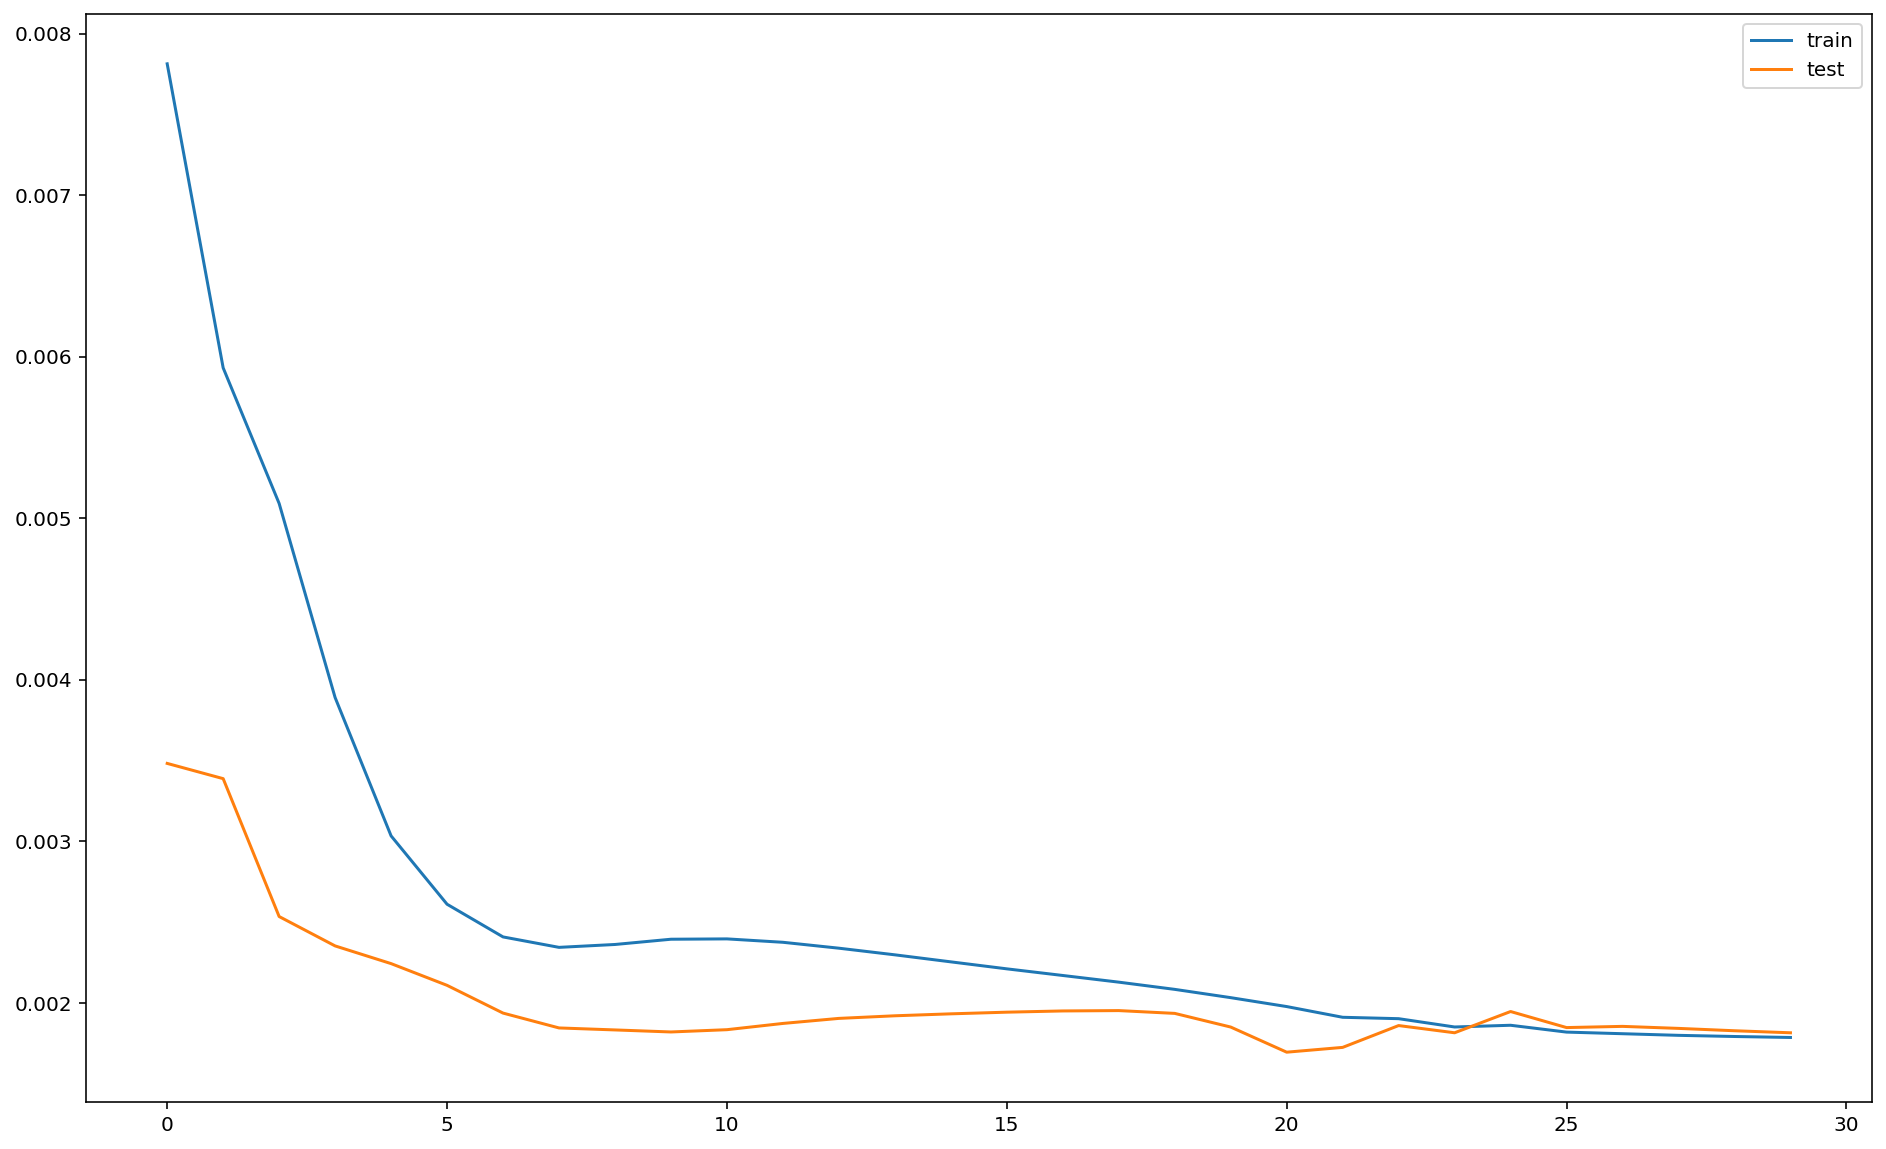

In [21]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [22]:
y_pred =serie_0_1_model.predict(X_test)


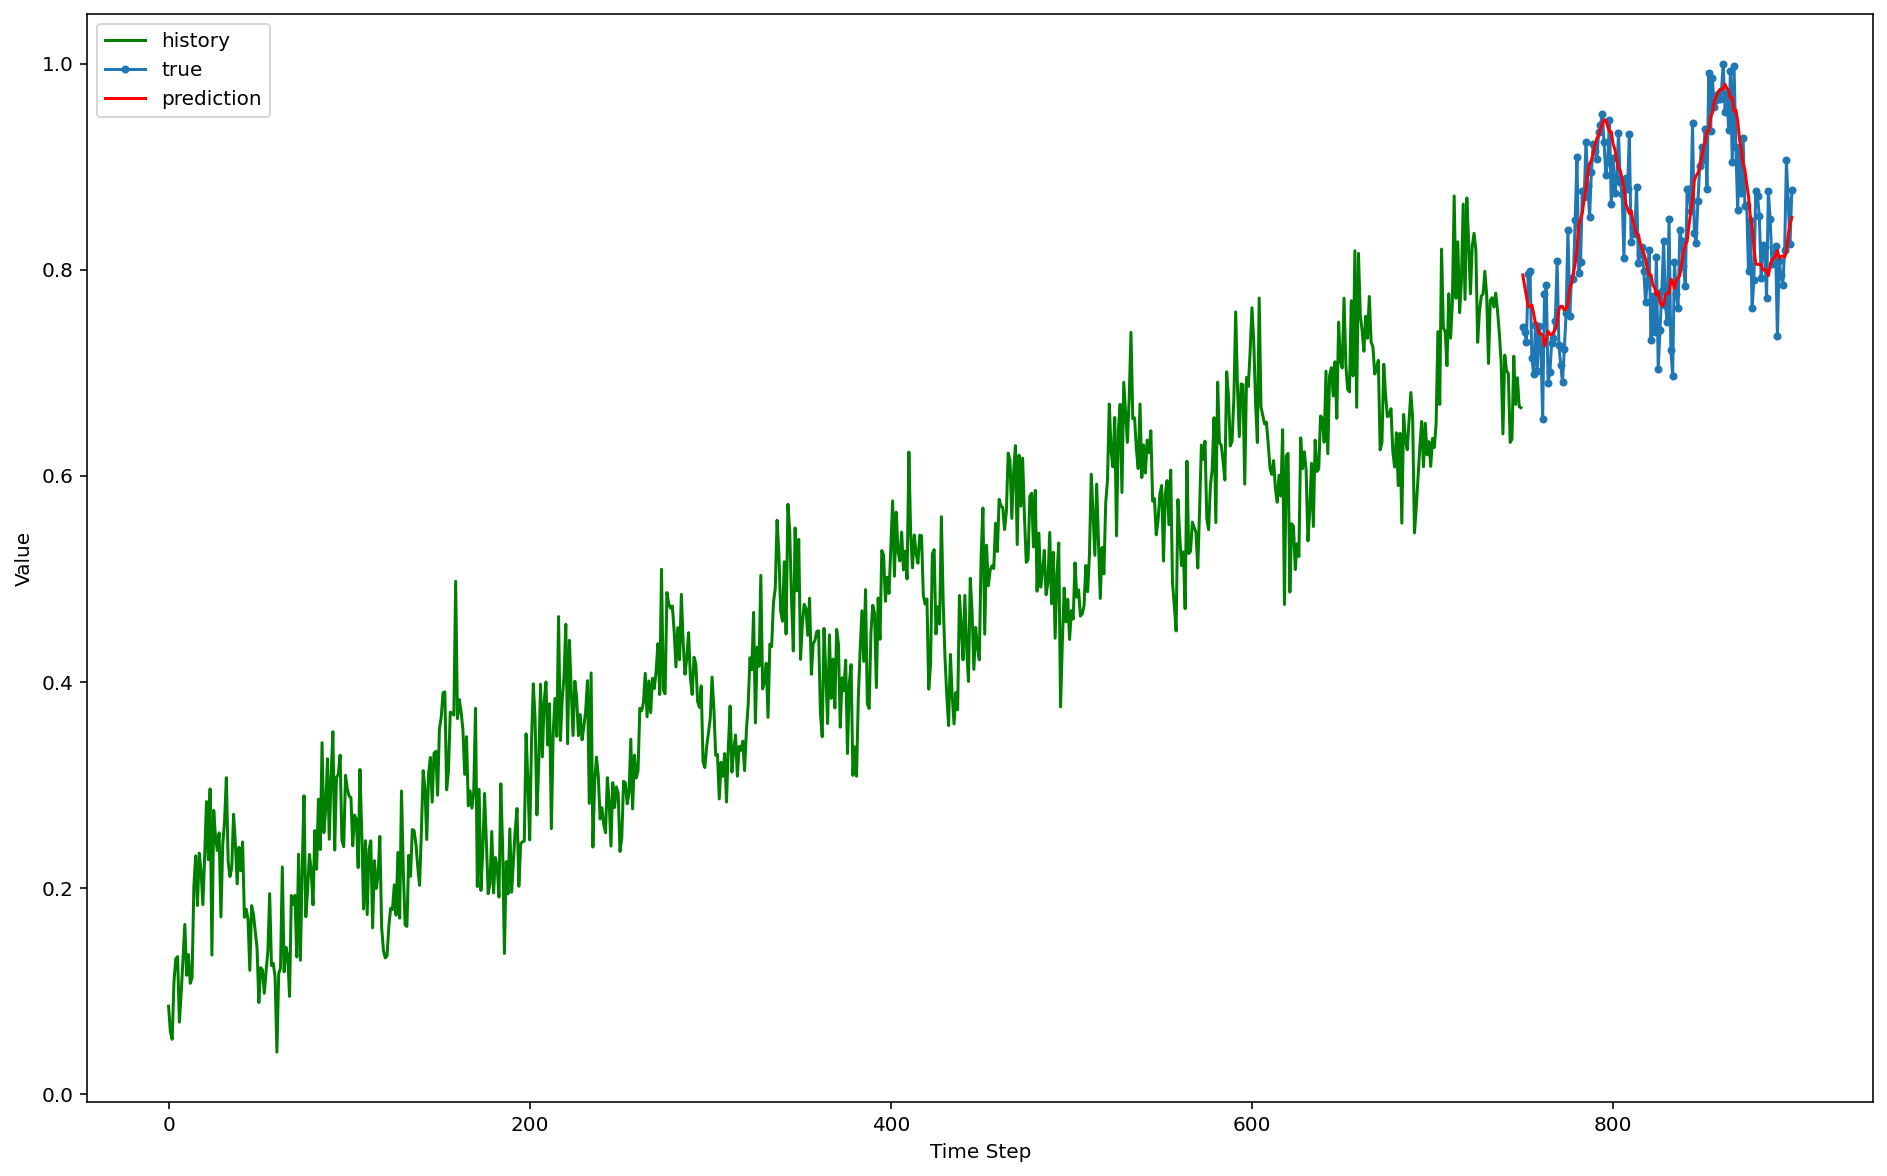

In [23]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

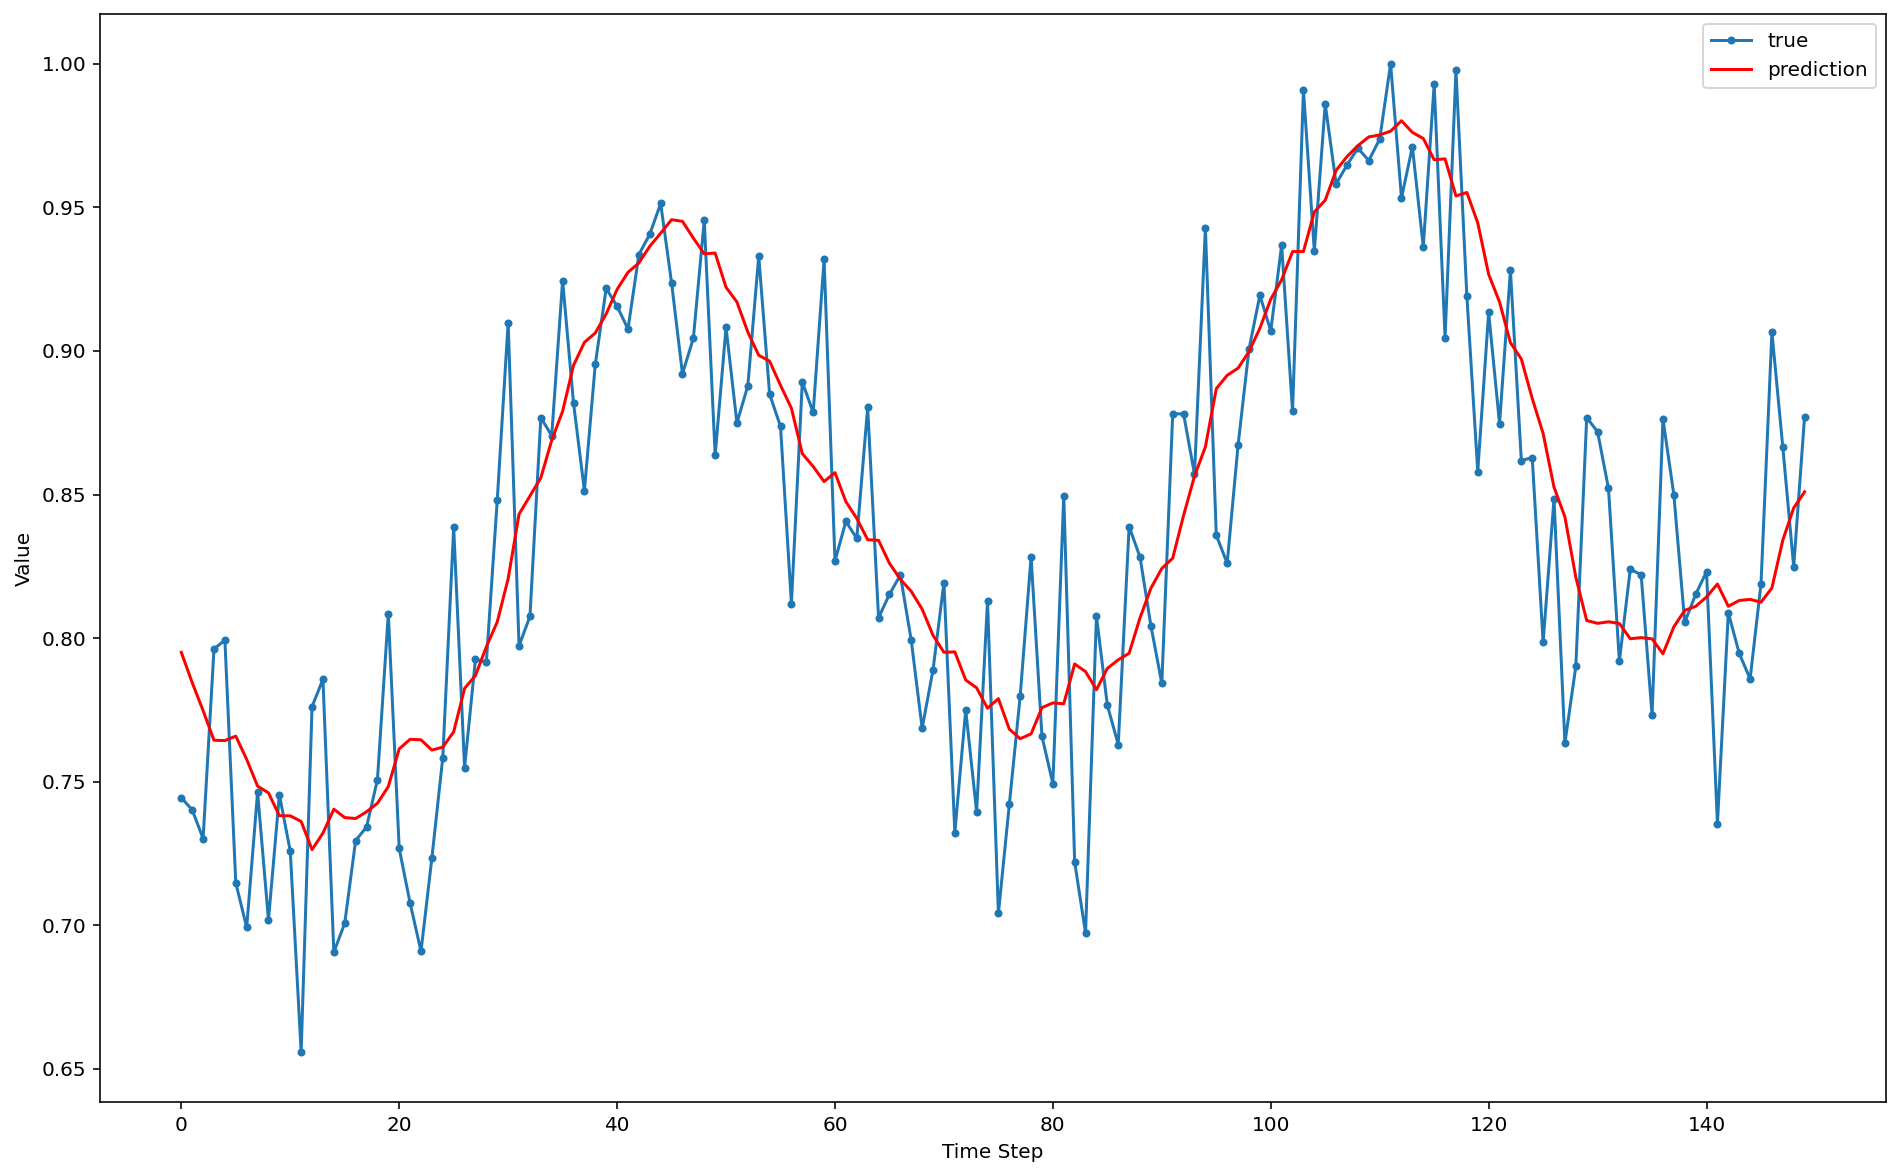

In [24]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [25]:
scaled_data = scaler.fit_transform(df1.values)
dataset = pd.DataFrame(scaled_data)
dataset.columns = ['sine']
dataset.index = df1.index


In [26]:
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))
y_test.shape

(150, 1)

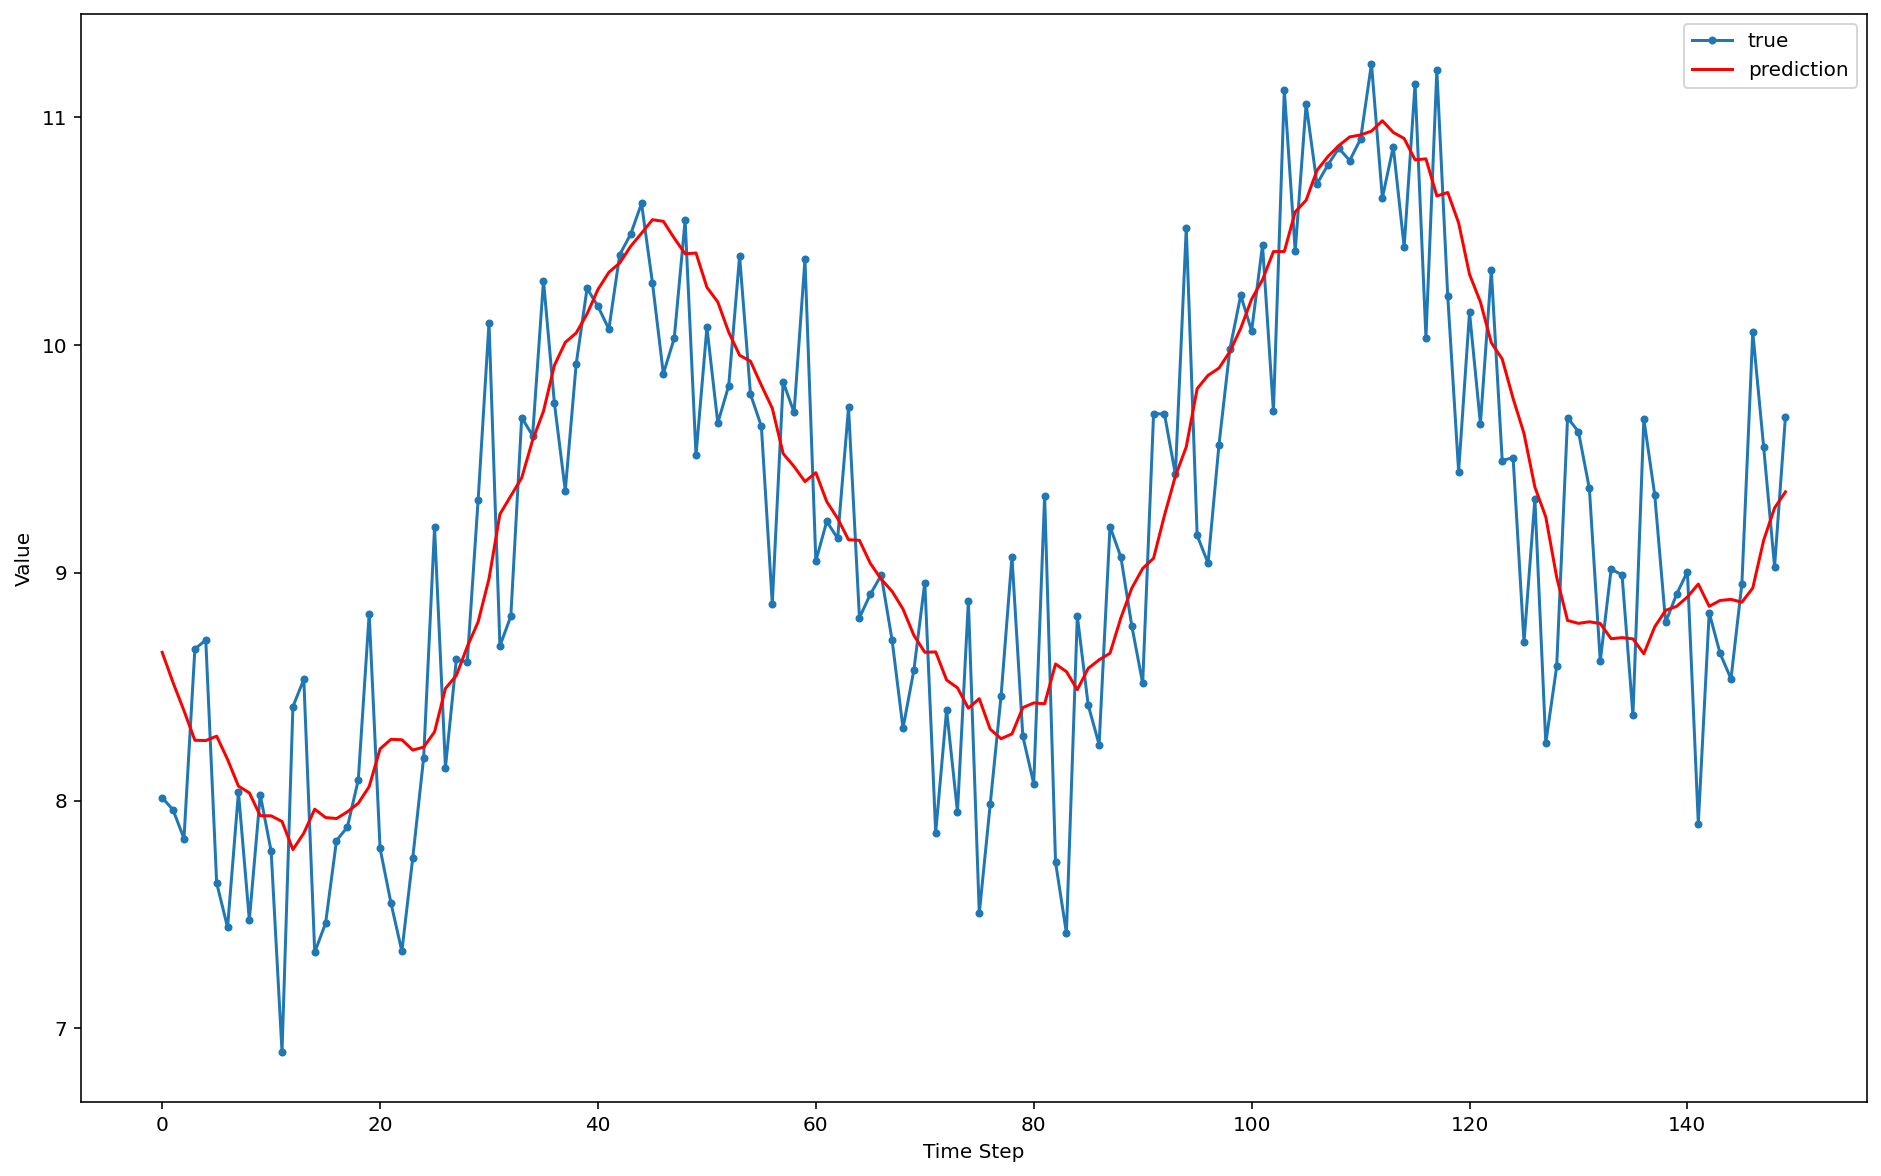

In [27]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [28]:
# shapes
inputs_shape = (X_train.shape[1], X_train.shape[2])
lstm_output = 60

# layers
inputs = Input(inputs_shape)
x = GRU(units=lstm_output, name='GRU_layer')(inputs)
outputs = Dense(1)(x)

# model
serie_0_1_model_gru = Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')


# summary
serie_0_1_model_gru.summary()


Model: "series_LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50, 1)]           0         
_________________________________________________________________
GRU_layer (GRU)              (None, 60)                11340     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 61        
Total params: 11,401
Trainable params: 11,401
Non-trainable params: 0
_________________________________________________________________


In [29]:
serie_0_1_model_gru.compile(loss='mean_squared_error',
  optimizer=Adam(0.001)
)

In [30]:

# entrena
history = serie_0_1_model_gru.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)


Epoch 1/30
43/43 [==============================] - 0s 11ms/step - loss: 0.0092 - val_loss: 0.0027
Epoch 2/30
43/43 [==============================] - 0s 4ms/step - loss: 0.0100 - val_loss: 0.0038
Epoch 3/30
43/43 [==============================] - 0s 5ms/step - loss: 0.0063 - val_loss: 0.0027
Epoch 4/30
43/43 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.0025
Epoch 5/30
43/43 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 6/30
43/43 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0021
Epoch 7/30
43/43 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 8/30
43/43 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 9/30
43/43 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 10/30
43/43 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 11/30
43/43 

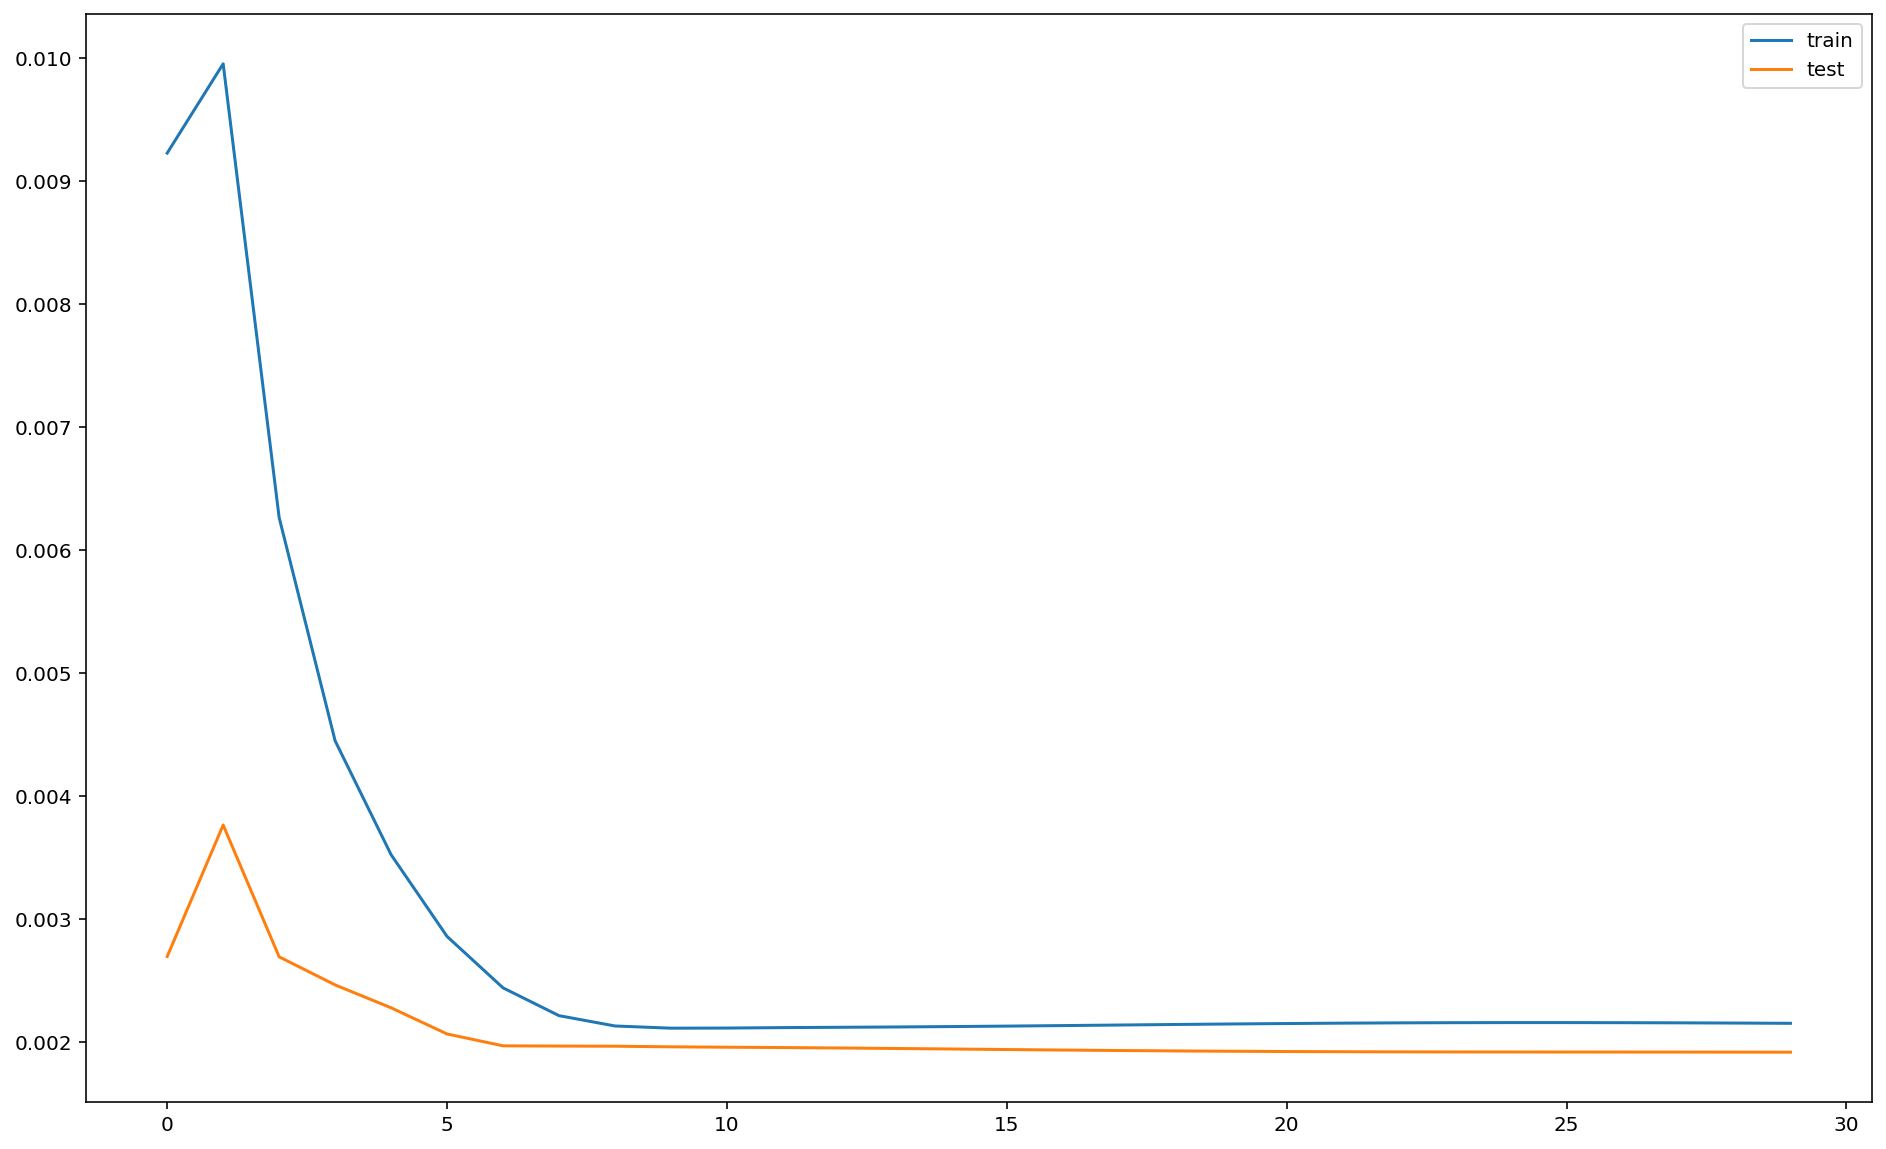

In [31]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [32]:
y_pred_gru =serie_0_1_model_gru.predict(X_test)
# escala original
y_pred_gru = scaler.inverse_transform(y_pred_gru)


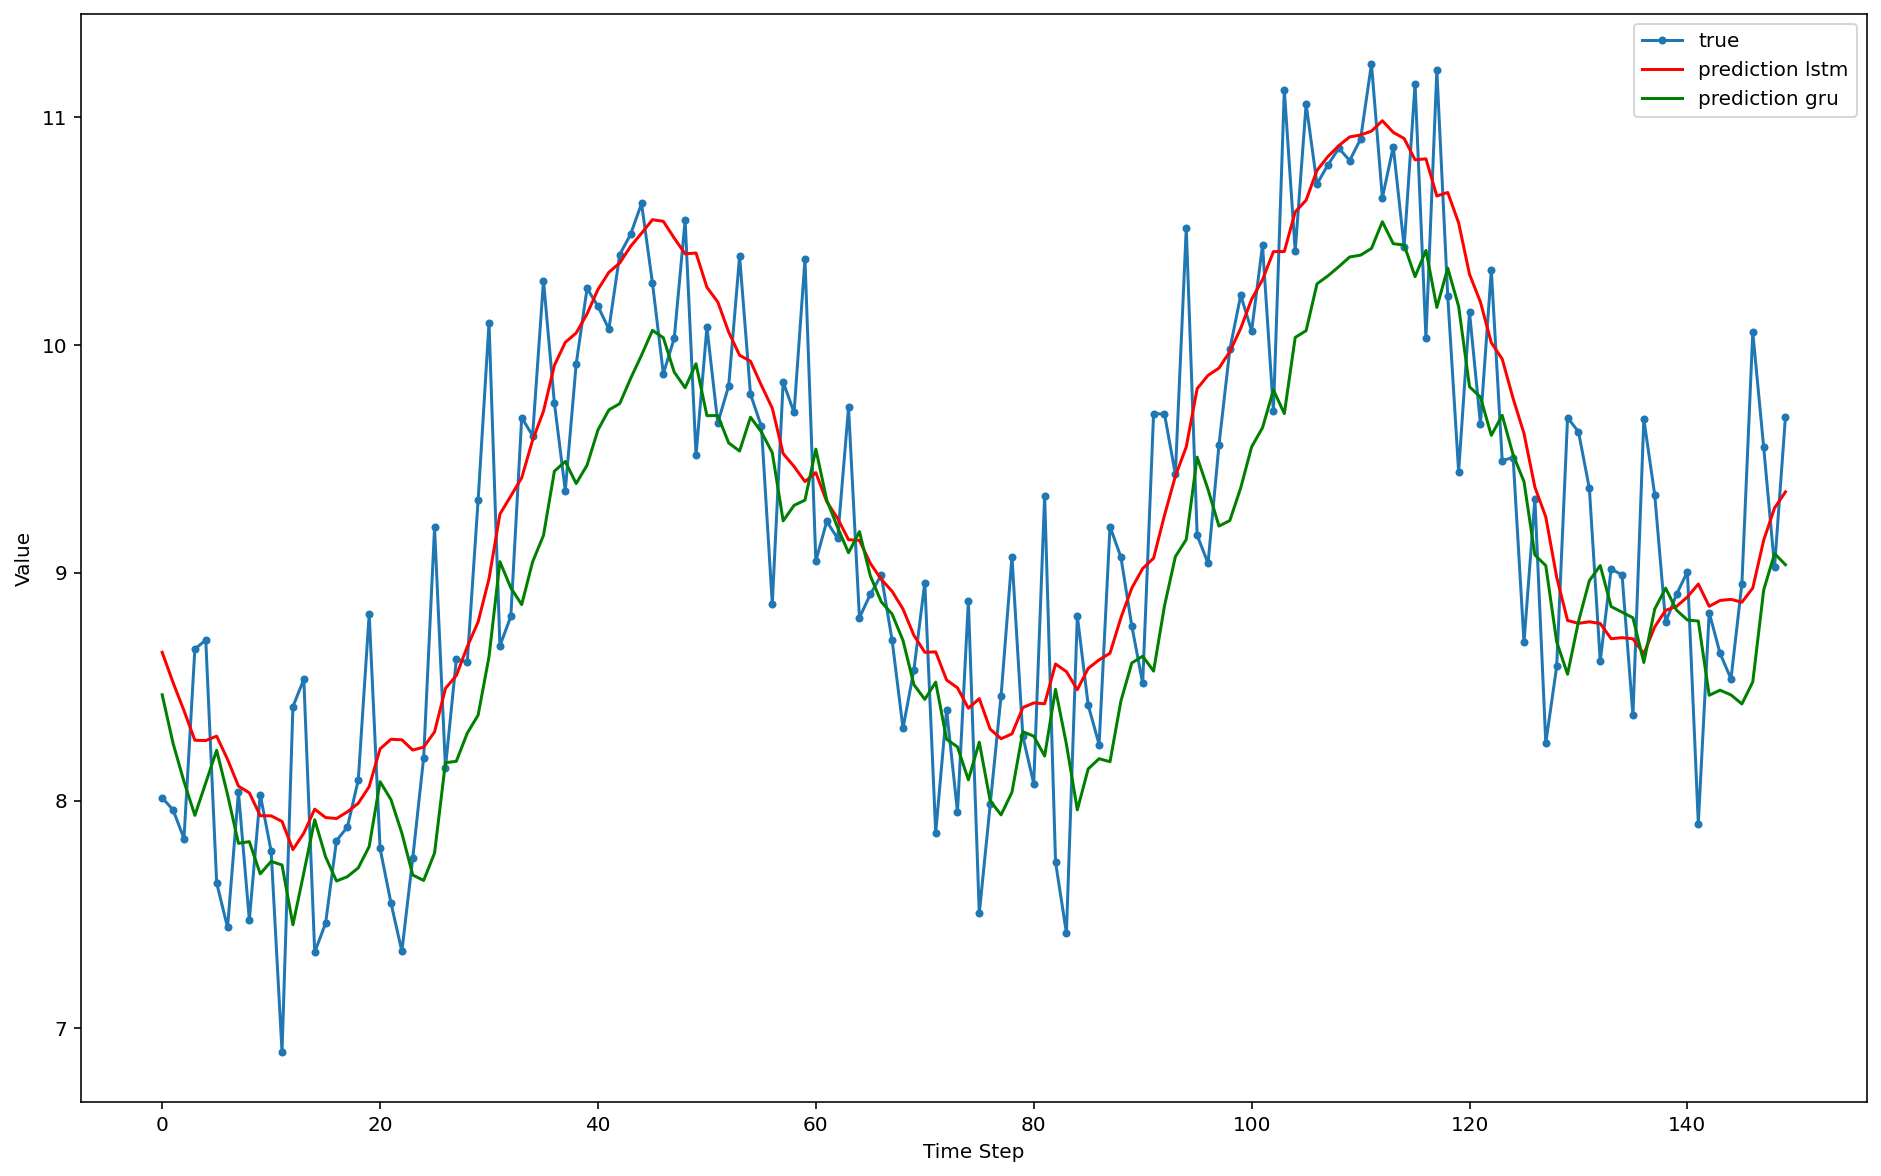

In [33]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction lstm")
plt.plot(y_pred_gru, 'g', label="prediction gru")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();
